# LSTM univariado para la ciudad de Quito

Se siguió el mismo procedimiento que con los datos de Cuenca.

Se importan las librerías.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Se importan los datos

In [ ]:
df = pd.read_csv('./drive/MyDrive/DatosInvestigacion/quito_2017_2018.csv', index_col=0, parse_dates=True)
df = df.asfreq('h')

In [ ]:
df = df.between_time('08:00:00','17:00:00')

In [ ]:
df.head()

,RS,VEL,TMP,HUM
Date_time,,,,
2017-02-01 08:00:00,259.93,0.41,13.90,73.92
2017-02-01 09:00:00,482.96,1.02,15.77,62.89
2017-02-01 10:00:00,608.28,1.65,17.13,53.35
2017-02-01 11:00:00,789.95,2.51,17.75,47.30
2017-02-01 12:00:00,975.22,2.79,18.63,46.45


Se dividen en datos de entrenamiento y prueba

In [ ]:
len_train = int(len(df)*0.8)
len_train

4120

In [ ]:
df_train = df.iloc[:len_train]
df_test = df.iloc[len_train:]

In [ ]:
df_train.tail(1)

,RS,VEL,TMP,HUM
Date_time,,,,
2018-03-19 17:00:00,17.45,1.64,12.03,86.27


In [ ]:
df_test.head(1)

,RS,VEL,TMP,HUM
Date_time,,,,
2018-03-20 08:00:00,258.22,0.69,14.26,72.94


## Creación del modelo

Se toma la variable de radiación solar.

In [ ]:
RSG = df_train['RS'].values

In [ ]:
RSG = np.reshape(RSG,(-1,1))

In [ ]:
RSG[:5]

array([[259.93],
       [482.96],
       [608.28],
       [789.95],
       [975.22]])

In [ ]:
RSG_test = df_test['RS'].values
RSG_test = np.reshape(RSG_test,(-1,1))

Se normalizan los datos.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(RSG)
scaled_train = scaler.transform(RSG)
scaled_test = scaler.transform(RSG_test)

In [ ]:
scaled_train[0]

array([0.22144695])

Se importan las librerías para crear el modelo.

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Se importa la librería para generar batches de entrenamiento.

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
n_input = 20 # horas hacia atrás
n_features = 0 # variables exógenas
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
X,y = generator[0]
print(f'Datos: \n{X.flatten()}')
print(f'Predicción: \n {y}')

Datos: 
[0.22144695 0.411457   0.51822318 0.67299664 0.83083712 0.41514594
 0.35368638 0.18957556 0.12652286 0.08387432 0.42534376 0.52070235
 0.77169487 0.46648435 0.38065907 0.38009678 0.17329483 0.03136022
 0.06358943 0.0184958 ]
Predicción: 
 [[0.40479477]]


In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features+1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(generator,epochs=15)

El error tiene su reducción más importante en las primeras 7 épocas.

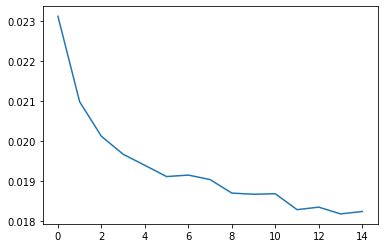

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Búsqueda de los mejores parámetros

Se crea una función para poder iterar sobre el número de capas y de neuronas.

In [ ]:
def create_Model(n_input, LSTM_neurons = 100, layers=3,n_features=0):
  # define model
  model = Sequential()
  if(layers>1):
    model.add(LSTM(LSTM_neurons, activation='relu', input_shape=(n_input, n_features+1),return_sequences=True))
    for i in range(layers-2):
        model.add(LSTM(LSTM_neurons, activation='relu',return_sequences=True))
    model.add(LSTM(LSTM_neurons, activation='relu'))
  else:
    model.add(LSTM(LSTM_neurons, activation='relu', input_shape=(n_input, n_features+1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
import json

Se importan los resultados anteriores en caso de que los haya. Esto debido al límite de tiempo que impone Colab.

In [ ]:
resultados=[]
combinaciones_anteriores = []
resultados_anteriores = []

In [ ]:
with open("./drive/MyDrive/DatosInvestigacion/resultados_LSTM_univariado_RS_quito.txt",'r') as fp:
    for line in fp:
      resultados_anteriores.append(json.loads(line))

In [ ]:
df_resultados_anteriores = pd.DataFrame(resultados_anteriores)
df_resultados = df_resultados_anteriores

Se almacenan las combinaciones anteriores para no volver a ejecutarlas.

In [ ]:
for i in range(len(df_resultados)):
  combinaciones_anteriores.append((int(df_resultados.iloc[i]['Retrasos']),
                                   int(df_resultados.iloc[i]['Neuronas LSTM']),
                                   int(df_resultados.iloc[i]['Batch size']),
                                   int(df_resultados.iloc[i]['LSTM Layers'])))

In [ ]:
len(df_resultados)

180

In [ ]:
df_resultados.tail(1)

,Retrasos,Neuronas LSTM,Batch size,LSTM Layers,MSE,MAE,RMSE
179,24,125,150,3,23946.235893,120.157339,154.745714


In [ ]:
df_resultados[df_resultados['RMSE']==df_resultados['RMSE'].min()]

,Retrasos,Neuronas LSTM,Batch size,LSTM Layers,MSE,MAE,RMSE
72,20,100,50,1,20709.393535,110.944899,143.907587


Se utiliza el RMSE para elegir al mejor modelo

In [ ]:
min_RMSE = 143.90758678869528

Se realizará la búsqueda de los mejores parámetros.

In [ ]:
for retrasos in range(16,26,2): #hasta dos días y medio hacia el pasado
  for num_neuronas in range(50,126,25): 
    for batch_size in range(50,151,50):
      for num_layers in range(1,4): 
        if((retrasos,num_neuronas,batch_size,num_layers) in combinaciones_anteriores):
          continue
        print({
            'Retrasos':retrasos,
            'Neuronas LSTM':num_neuronas,
            'Batch size':batch_size,
            'LSTM Layers': num_layers
        })
        n_input = retrasos # horas hacia atrás
        n_features = 0 # variables exógenas
        generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)  
        model = create_Model(n_input,LSTM_neurons=num_neuronas,layers=num_layers)
        model.fit(generator,epochs=7,verbose=False,batch_size=batch_size)
        predictions = []
        for j in range(n_input,len(df_test)):
          model_input = scaled_test[j-n_input:j]
          model_input = model_input.reshape((1, n_input, n_features+1))
          predictions.append(model.predict(model_input)[0])
        predictions = np.ndarray.flatten(np.array(predictions))  
        true_predictions = scaler.inverse_transform(np.reshape(predictions,(-1,1)))
        true_values = np.ndarray.flatten(df_test.iloc[n_input:]['RS'].values)
        errorMSE = mean_squared_error(true_values,true_predictions)
        errorMAE = mean_absolute_error(true_values,true_predictions)
        errorMSE = errorMSE
        errorRMSE = np.sqrt(errorMSE)
        if(errorRMSE<min_RMSE):
          print('BEST')
          model.save('./drive/MyDrive/DatosInvestigacion/LSTM_univariado_RS_quito.h5')
          min_RMSE = errorRMSE
        print('RMSE:',errorRMSE)
        print('MAE',errorMAE)
        print('Min RMSE',min_RMSE)

        resultado = {
            'Retrasos':retrasos,
            'Neuronas LSTM':num_neuronas,
            'Batch size':batch_size,
            'LSTM Layers': num_layers,
            'MSE':errorMSE,
            'MAE':errorMAE,
            'RMSE':errorRMSE
        }
        with open("./drive/MyDrive/DatosInvestigacion/resultados_LSTM_univariado_RS_quito.txt","a") as file:
          resultado = json.dumps(resultado)
          file.write(resultado)
          file.write('\n')

{'Retrasos': 22, 'Neuronas LSTM': 125, 'Batch size': 100, 'LSTM Layers': 2}
RMSE: 146.58877477695466
MAE 114.24878867595915
Min RMSE 143.90758678869528
{'Retrasos': 22, 'Neuronas LSTM': 125, 'Batch size': 100, 'LSTM Layers': 3}
RMSE: 148.2588517155545
MAE 113.77763317274669
Min RMSE 143.90758678869528
{'Retrasos': 22, 'Neuronas LSTM': 125, 'Batch size': 150, 'LSTM Layers': 1}
RMSE: 146.88647112649878
MAE 115.1988072307526
Min RMSE 143.90758678869528
{'Retrasos': 22, 'Neuronas LSTM': 125, 'Batch size': 150, 'LSTM Layers': 2}
RMSE: 157.36864068968836
MAE 126.12968129112606
Min RMSE 143.90758678869528
{'Retrasos': 22, 'Neuronas LSTM': 125, 'Batch size': 150, 'LSTM Layers': 3}
RMSE: 148.78433197360448
MAE 112.90440284002395
Min RMSE 143.90758678869528
{'Retrasos': 24, 'Neuronas LSTM': 125, 'Batch size': 50, 'LSTM Layers': 1}
RMSE: 148.6919512081992
MAE 112.1947886221641
Min RMSE 143.90758678869528
{'Retrasos': 24, 'Neuronas LSTM': 125, 'Batch size': 50, 'LSTM Layers': 2}
RMSE: 158.59494483

## Gráfico de resultados

In [ ]:
import seaborn as sns

### Número de retrasos

El mejor número de retrasos es 20.

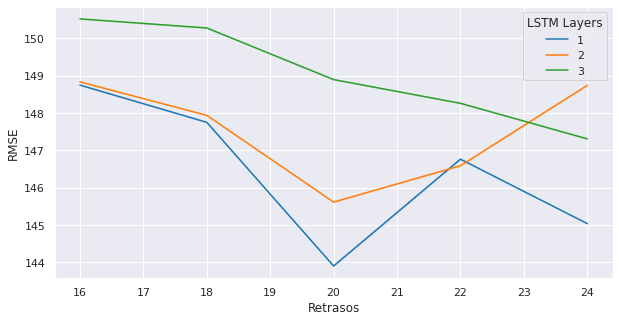

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.lineplot(data=df_resultados, x='Retrasos', y='RMSE',hue='LSTM Layers',palette='tab10',ci=0, estimator=np.min)

### Número de neuronas LSTM

El mejor número de neuronas es 100.

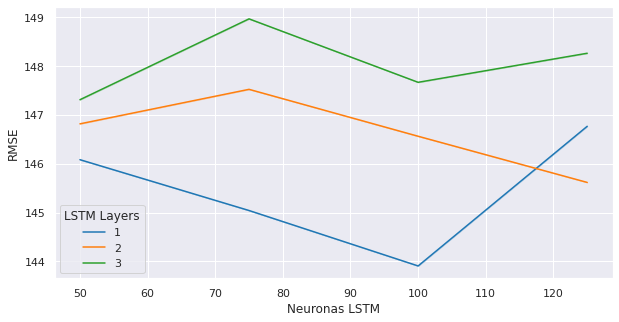

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.lineplot(data=df_resultados, x='Neuronas LSTM', y='RMSE',hue='LSTM Layers',palette='tab10', ci=0, estimator=np.min)

### Batch size

El mejor batch size es de 50.

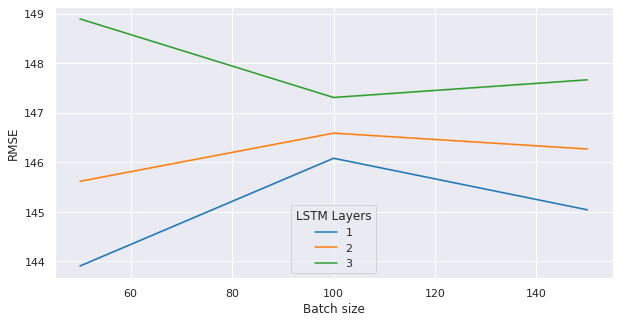

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.lineplot(data=df_resultados, x='Batch size', y='RMSE',hue='LSTM Layers',palette='tab10', ci=0, estimator=np.min)